In [17]:
# 定义一个句子列表
sentences = [
    "Kage is Teacher",
    "Mazaong is Boss",
    "Niuzong is Boss",
    "Xiaobing is Student",
    "Xiaoxue is Student",
]
# 将所有的句子连接在一起，然后使用空格分割多个单词
words = " ".join(sentences).split()
# 构建词汇表，使用set去重
word_list = list(set(words))
# 创建一个字典，将每个词映射到唯一的索引
word_to_idx = {word: i for i, word in enumerate(word_list)}
# 创建一个字典，将每个索引映射到唯一的词
idx_to_word = {i: word for i, word in enumerate(word_list)}
voc_size = len(word_list)  # 词汇表大小
print("词汇表：", word_list)
print("词汇到索引的字典：", word_to_idx)
print("索引到词汇的字典：", idx_to_word)
print("词汇表大小：", voc_size)

词汇表： ['Xiaoxue', 'is', 'Niuzong', 'Kage', 'Xiaobing', 'Teacher', 'Mazaong', 'Student', 'Boss']
词汇到索引的字典： {'Xiaoxue': 0, 'is': 1, 'Niuzong': 2, 'Kage': 3, 'Xiaobing': 4, 'Teacher': 5, 'Mazaong': 6, 'Student': 7, 'Boss': 8}
索引到词汇的字典： {0: 'Xiaoxue', 1: 'is', 2: 'Niuzong', 3: 'Kage', 4: 'Xiaobing', 5: 'Teacher', 6: 'Mazaong', 7: 'Student', 8: 'Boss'}
词汇表大小： 9


In [19]:
# 生成Skip-Gram训练数据
def create_skipgram_dataset(sentences, window_size=2):
    data = []
    for sentence in sentences:  # 遍历每个句子
        sentence = sentence.split()  # 将句子分割成单词
        for idx, word in enumerate(sentence):  # 遍历单词及其索引
            # 获取相邻单词，将当前的单词和后N个单词组成一个元组
            for neighbor in sentence[max(idx - window_size, 0): min(idx + window_size + 1, len(sentence))]:
                if neighbor != word:  # 排除当前的单词本身
                    data.append((neighbor, word))  # 将相邻单词和当前单词组成一个元组
    return data
# 使用函数创建Skip-Gram训练数据
skipgram_data = create_skipgram_dataset(sentences)
# 打印Skip-Gram训练数据（前三个）
print("Skip-Gram训练数据：", skipgram_data[:3])

Skip-Gram训练数据： [('is', 'Kage'), ('Teacher', 'Kage'), ('Kage', 'is')]


In [20]:
# 定义One-hot编码函数
import torch
def one_hot_encoding(word, word_to_idx):
    one_hot = torch.zeros(len(word_to_idx))
    one_hot[word_to_idx[word]] = 1
    return one_hot
# 测试One-hot编码函数
word_example = "Teacher"
print("One-Hot编码前的单词：", word_example)
print("One-Hot编码后的向量：", one_hot_encoding(word_example, word_to_idx))
#展示编码后的SKip-Gram数据
print("Skip-Gram数据样例（已编码）：", [(one_hot_encoding(context, word_to_idx), word_to_idx[target]) for context, target in skipgram_data[:3]])

One-Hot编码前的单词： Teacher
One-Hot编码后的向量： tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.])
Skip-Gram数据样例（已编码）： [(tensor([0., 1., 0., 0., 0., 0., 0., 0., 0.]), 3), (tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.]), 3), (tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.]), 1)]


In [21]:
# 定义Skip-Gram类
import torch.nn as nn
class SkipGram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super(SkipGram, self).__init__()
        # 从词汇表大小到嵌入层大小（维度）的线性层（权重矩阵）
        self.input_to_hidden = nn.Linear(voc_size, emb_size, bias=False)
        # 从嵌入层大小（维度）到词汇表大小的线性层（权重矩阵）
        self.hidden_to_output = nn.Linear(emb_size, voc_size, bias=False)
    def forward(self, X):
        # 通过隐藏层，hidden形状为[batch_size, emb_size]
        hidden = self.input_to_hidden(X)
        # 通过输出层，output形状为[batch_size, voc_size]
        output = self.hidden_to_output(hidden)
        return output
    
embedding_sie = 2  # 嵌入层大小（维度）
skipgram_model = SkipGram(voc_size, embedding_sie)
print("Skip-Gram模型：", skipgram_model)

Skip-Gram模型： SkipGram(
  (input_to_hidden): Linear(in_features=9, out_features=2, bias=False)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)


Epoch: 100, Loss: 2.1557007789611817
Epoch: 200, Loss: 2.110730202992757
Epoch: 300, Loss: 2.054807488123576
Epoch: 400, Loss: 1.9878742933273315
Epoch: 500, Loss: 1.9212834338347118
Epoch: 600, Loss: 1.8698581755161285
Epoch: 700, Loss: 1.8356786211331686
Epoch: 800, Loss: 1.811363019545873
Epoch: 900, Loss: 1.7910013318061828
Epoch: 1000, Loss: 1.7719860136508943


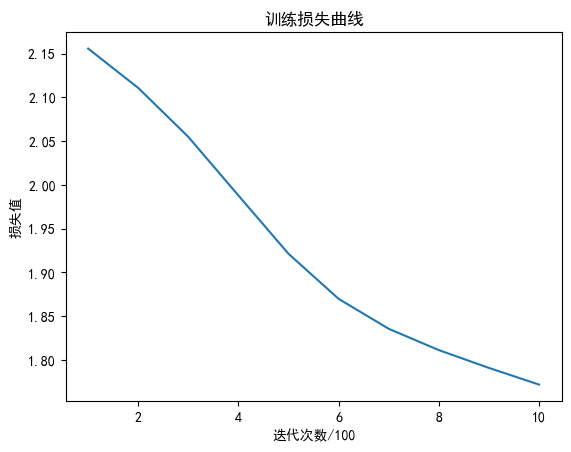

In [22]:
# 训练
learning_rate = 0.001  # 学习率
epochs = 1000  # 迭代次数
criterion = nn.CrossEntropyLoss()  # 损失函数
import torch.optim as optim # 优化器
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)  # 随机梯度下降优化器
# 开始训练
loss_values = []  # 保存损失值
for epoch in range(epochs):
    loss_sum = 0
    for context, target in skipgram_data:
        X = one_hot_encoding(target, word_to_idx).float().unsqueeze(0) # 将中心词转化为向量
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long) # 将周围词转化为索引
        y_pred = skipgram_model(X)  # 前向传播
        loss = criterion(y_pred, y_true) # 计算损失
        loss_sum += loss.item() # 累加损失
        optimizer.zero_grad() # 梯度清零
        loss.backward()  # 反向传播
        optimizer.step() # 更新参数
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1}, Loss: {loss_sum/len(skipgram_data)}")
        loss_values.append(loss_sum / len(skipgram_data))
# 绘制损失曲线
import matplotlib.pyplot as plt
# 绘制二维向量图
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 显示负号
plt.plot(range(1, epochs // 100 + 1), loss_values)
plt.title("训练损失曲线")
plt.xlabel("迭代次数/100")
plt.ylabel("损失值")
plt.show()

In [23]:
# 输出Skip-Gram模型的词向量
print("Skip-Gram模型的词向量：")
for word, idx in word_to_idx.items():
    print(f"{word}: {skipgram_model.input_to_hidden.weight[:, idx].detach().numpy()}")

Skip-Gram模型的词向量：
Xiaoxue: [-0.23853526 -0.51777107]
is: [ 0.7273898  -0.24968545]
Niuzong: [-0.67761344 -0.9186725 ]
Kage: [-0.96088105  0.1863214 ]
Xiaobing: [-0.10231111 -0.84958816]
Teacher: [-0.68329275 -0.46443117]
Mazaong: [-0.5448265  -0.99111724]
Student: [-0.896637   0.1306958]
Boss: [-0.88182503 -0.21921562]


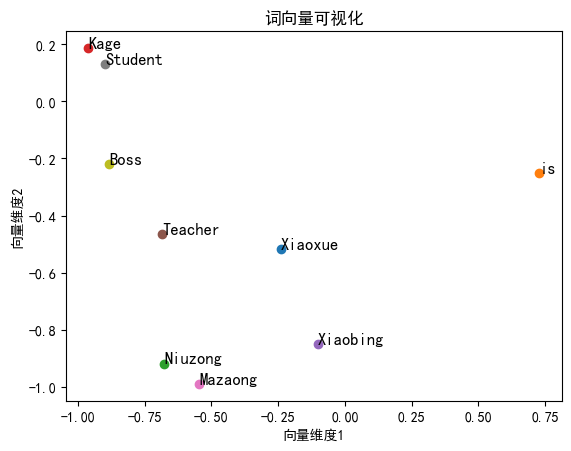

In [24]:
# 可视化词向量
fig, ax = plt.subplots()
for word, idx in word_to_idx.items():
    # 获取词向量
    vec = skipgram_model.input_to_hidden.weight[:, idx].detach().numpy()
    ax.scatter(vec[0], vec[1]) # 绘制点
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 添加标签
plt.title("词向量可视化")
plt.xlabel("向量维度1")
plt.ylabel("向量维度2")
plt.show()